#SAT encoding for the VLSI problem

Combinatorial and Decision Making Optimization Module I project

Farinola Francesco - francesco.farinola@studio.unibo.it

This is an adaption of the paper *A SAT-based Method for Solving the
Two-dimensional Strip Packing Problem* by Takehide Soh, Katsumi Inoue, Naoyuki Tamura, Mutsunori Banbara, and Hidetomo Nabeshima to the VLSI problem.

In [1]:
!git clone https://github.com/FrancescoFarinola/VLSI_CDMO
!pip install z3-solver
from z3 import *
%cd VLSI_CDMO/SAT/src

fatal: destination path 'VLSI_CDMO' already exists and is not an empty directory.


C:\Users\francesco.farinola\VLSI_CDMO\SAT


You should consider upgrading via the 'c:\users\francesco.farinola\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
from VLSI_CDMO.utils import input, output
#from utils import input, output
import os
import time
import re
import numpy as np

#Model explanation

The SAT problem using order encoding is as follow:

Let $c_i$ and $c_j \in R (i \neq j)$ be two circuits and $e$ and $f$ any integers. Then the SAT encoding uses four kinds of atoms:

  - $lr_{i,j}$ is True if circuit $r_i$ is placed at the left to the circuit $r_j$, False otherwise
  - $ud_{i,j}$ is True if circuit $r_i$ is placed at the downside w.r.t. to the circuit $r_j$, False otherwise
  - $x_{i,e}$ is True if circuit $r_i$ is placed at less or equal to $e$
  - $y_{i,f}$ is True if circuit $r_i$ is placed ar less or equal to $f$

Furthermore, when searching for a solution using a SAT encoding, we want to find as first the optimal solution. In order to do so, we need to fix the value of the plate height ($plate_h$) and find a feasible assignment to all the variables we defined before which satisfies all the constraints we are going to define.

To find the optimal value of $plate_h$, we calculate the sum of the areas of circuits and divide it by the plate width. By getting the upper bound of this value we can approximate the optimal value of the plate height.

# Define constraints

## Reduce domain

With this constraint we force coordinate values to be True when they would exceed the plate maximum width or height.

By setting those as True we restrict the domain values since we have to take the coordinate which has the lowest True value.

In [3]:
def reduce_domain(n, plate_w, plate_h, width, height, x , y):
  '''
  @args:
    - n: number of circuits (int)
    - plate_w: maximum width of the plate (int)
    - plate_h: maximum height of the plate (int)
    - width: list of widths of the circuits (list of int)
    - height: list of heights of the circuits (list of int)
    - x: set of bool values indicating every x coordinate in the plate grid (list of list of Bool)
    - y: set of bool values indicating every y coordinate in the plate grid (list of list of Bool)
  '''
  clauses = []
  for i in range(n): 
    # Variables exceeding the constraints are set to true
    for e in range(plate_w - width[i], plate_w):             # For each value in between max-width and max 
      clauses.append(x[i][e])
    for f in range(plate_h - height[i], plate_h):            # For each value in between max-height and max
      clauses.append(y[i][f])
  return clauses

## No overlap constraint

For ensuring no overlapping for circuits we need different kind of clauses:
  - 2-literal clauses: for each circuit $c_i$ and predefined integer $e$ and $f$ such that $0 \leq e < plate\_w - width_i$ and $0 \leq f < plate\_h - height_i$ we have:

  $\lnot{x}_{i,e} \lor x_{i,e+1}$

  $\lnot{y}_{i,f} \lor y_{i,f+1}$

  - 3-literal clauses: for each circuits $c_i$ and $c_j$ with $i< j$ and predefined integer $e$ and $f$ such that $0 \leq e < plate\_w - width_i$ and $0 \leq f < plate\_h - height_i$

  $\lnot{lr}_{i,j} \lor x_{i,e} \lor \lnot{x}_{j,e+width_i}$
  $\lnot{lr}_{j,i} \lor x_{j,e} \lor \lnot{x}_{i,e+width_j}$
  $\lnot{ud}_{i,j} \lor y_{i,f} \lor \lnot{y}_{j,f+height_i}$
  $\lnot{ud}_{j,i} \lor y_{j,f} \lor \lnot{y}_{i,f+height_j}$

  To ensure no overlapping and assignments of atoms it was added four more clauses to each of the previous with inverted values of i and j, and are:

  $ \lnot{lr}_{i,j} \lor \lnot{x}_{j,width_i-1} $

  $ \lnot{lr}_{i,j} \lor x_{i,plate_w - width_i-1} $

  $ \lnot{ud}_{i,j} \lor \lnot{y}_{j,height_i-1} $

  $ \lnot{ud}_{i,j} \lor y_{i,plate_h - height_i-1} $

  where $plate_w - width_i - 1$ and $plate_h - height_i - 1$ represent the maximum value that the coordinate x or y can assume if the first circuit is at the right side or upside w.r.t. the second circuit.

  - 4-literal clauses: for each circuits $c_i$ and $c_j$ with $i < j$ we have:

  $lr_{i,j} \lor lr_{j,i} \lor ud_{i,j} \lor ud_{j,i}$ 

  so for each couple of rectangles only one of these is TRUE to ensure an ordering.


In [4]:
def no_overlap_2(coord, d, n):
    '''
    Two calls have to be made on this method for each coordinate: (x, e, n) and (y, f, n)
    @args:
      - coord: set of bool values indicating every x/y coordinate in the plate grid (list of list of Bool)
      - d: the set of possible values for each circuit (list of int)
      - n: number of circuits (int)
    '''
    clauses = []
    for i in range(n):
        for k in d[i]:
            clauses.append(Or(Not(coord[i][k]), coord[i][k+1]))
    return clauses
      

def no_overlap_3(direction, coord, size, max_size):
    '''
    Two calls have to be made on this method for each direction: (lr, x, width, plate_w) and (ud, y, height, plate_h)
    @args:
      - direction: set of bool values indicating the direction where is placed the circuits (list of list of Bool)
      - coord: set of bool values indicating every x/y coordinate in the plate grid (list of list of Bool)
      - size: list of widths or heights of the circuits (list of int)
      - max_size: maximum width or height of the plate (int)
    '''
    clauses = []
    for i in range (len(size)):
        for j in range(i+1, len(size)):
            clauses.append(Or(Not(direction[i][j]),Not(coord[j][size[i]-1])))
            clauses.append(Or(Not(direction[j][i]),Not(coord[i][size[j]-1])))
            for e in range(max_size - size[i] - 1):
                clauses.append(Or(Not(direction[i][j]),coord[i][e],Not(coord[j][e + size[i]])))
            for e in range(max_size - size[j] - 1):
                clauses.append(Or(Not(direction[j][i]),coord[j][e],Not(coord[i][e + size[j]])))
            clauses.append(Or(Not(direction[i][j]),coord[i][max_size-size[i]-1]))
            clauses.append(Or(Not(direction[j][i]),coord[j][max_size-size[j]-1]))
    return clauses


def no_overlap_4(lr, ud, n):
    '''
    @args:
      - lr: set of bool values indicating whether the circuit i is placed at the left w.r.t. the circuit j (list of list of Bool)
      - ud: set of bool values indicating whether the circuit i is placed at the downside w.r.t. the circuit j (list of list of Bool)
      - n: number of circuits (int)
    '''
    clauses = []
    for i in range(n):
        for j in range(i+1, n):
            clauses.append(Or(lr[i][j], lr[j][i], ud[i][j], ud[j][i]))
    return clauses

##Largest circuit

With this constraint, we lookup for the circuit with the maximum area and then force the domain of the other circuits to be at right side or upside w.r.t to it. 

If for each circuit $i$, $width_i > \frac{plate_w - width_{max}}{2}$ we add the clause:

$lr_{i,max} = False$

If for each circuit $i$, $height_i > \frac{plate_h - height_{max}}{2}$ we add the clause:

$ud_{i,max} = False$




In [5]:
def max_circuit(width, height, lr, ud, plate_w, plate_h):
    '''
    @args:
      - width: list of widths of the circuits (list of int)
      - height: list of heights of the circuits (list of int)
      - lr: set of bool values indicating whether the circuit i is placed at the left w.r.t. the circuit j (list of list of Bool)
      - ud: set of bool values indicating whether the circuit i is placed at the downside w.r.t. the circuit j (list of list of Bool)
      - plate_w: maximum width of the plate (int)
      - plate_h: maximum height of the plate (int)
    '''
    clauses = []
    index = np.argmax([height[i] * width[i] for i in range(len(width))])
    for i in range(len(width)):
        if i != index:
            if width[i] > int((plate_w - width[index])/2):
                clauses.append(lr[i][index]==False)
            if height[i] > int((plate_h - height[index])/2):
                clauses.append(ud[i][index]==False)
    return clauses

## Large circuits

When we have large circuits, if the sum of their sizes exceeds the maximum size of the plate we can force the direction variable to be false in both circuits. 

So for each couple of circuits $c_i$, $c_j$ if $width_i + width_j > plate_w$ we can set:

$lr_{i,j} = False$

$lr_{j,i} = False$

For each couple of circuits $c_i$, $c_j$ if $height_i + height_j > plate_h$ we can set:

$ud_{i,j} = False$

$ud_{j,i} = False$





In [6]:
def large_circuits(width, height, lr, ud, plate_w, plate_h):
    '''
    @args:
      - width: list of widths of the circuits (list of int)
      - height: list of heights of the circuits (list of int)
      - lr: set of bool values indicating whether the circuit i is placed at the left w.r.t. the circuit j (list of list of Bool)
      - ud: set of bool values indicating whether the circuit i is placed at the downside w.r.t. the circuit j (list of list of Bool)
      - plate_w: maximum width of the plate (int)
      - plate_h: maximum height of the plate (int)
    '''
    clauses = []
    for i in range(len(width)):
        for j in range(i+1,len(width)):
            if width[i] + width[j] > plate_w:
                clauses.append(lr[i][j] == False)
                clauses.append(lr[j][i] == False)
            if height[i] + height[j] > plate_h:
                clauses.append(ud[i][j] == False)
                clauses.append(ud[j][i] == False)
    return clauses

##Same circuits

Circuits of the same dimension can fix their positional relation by adding the clauses:

$lr_{j,i}= False$

$lr_{i,j} \lor \lnot{ud}_{j,i}$

In [7]:
def same_size(width, height, lr, ud):
    '''
    @args:
      - width: list of widths of the circuits (list of int)
      - height: list of heights of the circuits (list of int)
      - lr: set of bool values indicating whether the circuit i is placed at the left w.r.t. the circuit j (list of list of Bool)
      - ud: set of bool values indicating whether the circuit i is placed at the downside w.r.t. the circuit j (list of list of Bool)
    '''
    clauses = []
    for i in range(len(width)):
        for j in range(i+1,len(width)):
            if width[i] == width[j] and height[i] == height[j]:
                clauses.append(lr[j][i] == False)
                clauses.append(Or(lr[i][j], Not(ud[j][i])))
    return clauses

#Auxiliary functions

As we said before, the value of $x_{i,j}$ is True when the circuit $i$ occupies the position j in the plate grid. So by getting the lowest True value we get the bottom-left corner coordinate x of the circuit $i$. Same goes for the y coordinate.

So we scan the $c_x$ and $c_y$ from the lower bound and when we find a True value we break the loop for the current circuit and get the coordinate position.

In [8]:
def evaluate_solution(m, c_x, c_y, n, plate_w, plate_h):
  x = []
  y = [] 
  for i in range(n):           # For each circuit
    j = 0
    while j < plate_w:
      if m.evaluate(c_x[i][j]): # When we find a True value we stop and get the x coordinate.
        x.append(j)
        break
      j += 1
    j = 0
    while j < plate_h:
      if m.evaluate(c_y[i][j]): # When we find a True value we stop and get the y coordinate
        y.append(j)
        break
      j += 1
  return [x, y]

Simple auxiliary function to write the output file with the solution

In [9]:
def write_output(path, i, plate_w, plate_h, circuits):
    out_file = path + "/out-" + str(i) + ".txt"
    with open(out_file, 'w') as f:
        f.write("{0} {1}\n".format(plate_w, plate_h))
        f.write("{0}\n".format(len(circuits)))
        for i in range(0,len(circuits)):
            f.write("{0} {1} {2} {3}\n".format(circuits[i][0], circuits[i][1], circuits[i][2], circuits[i][3]))
        f.close()
    return out_file

#Model

['../instances/ins-1.txt', '../instances/ins-2.txt', '../instances/ins-3.txt', '../instances/ins-4.txt', '../instances/ins-5.txt', '../instances/ins-6.txt', '../instances/ins-7.txt', '../instances/ins-8.txt', '../instances/ins-9.txt', '../instances/ins-10.txt', '../instances/ins-11.txt', '../instances/ins-12.txt', '../instances/ins-13.txt', '../instances/ins-14.txt', '../instances/ins-15.txt', '../instances/ins-16.txt', '../instances/ins-17.txt', '../instances/ins-18.txt', '../instances/ins-19.txt', '../instances/ins-20.txt', '../instances/ins-21.txt', '../instances/ins-22.txt', '../instances/ins-23.txt', '../instances/ins-24.txt', '../instances/ins-25.txt', '../instances/ins-26.txt', '../instances/ins-27.txt', '../instances/ins-28.txt', '../instances/ins-29.txt', '../instances/ins-30.txt', '../instances/ins-31.txt', '../instances/ins-32.txt', '../instances/ins-33.txt', '../instances/ins-34.txt', '../instances/ins-35.txt', '../instances/ins-36.txt', '../instances/ins-37.txt', '../insta

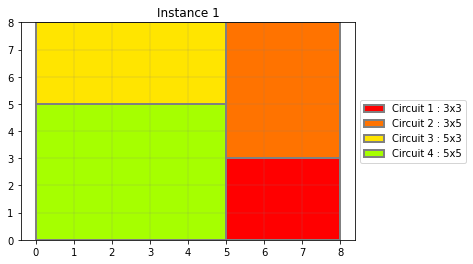

Plate width: 8
Plate height: 8
Elapsed time: 0.006s

Solving instance 2


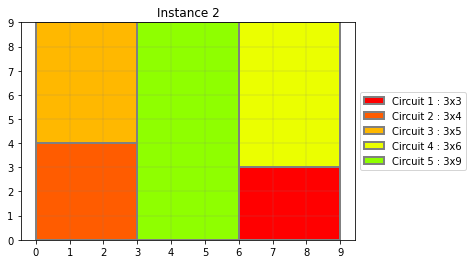

Plate width: 9
Plate height: 9
Elapsed time: 0.006s

Solving instance 3


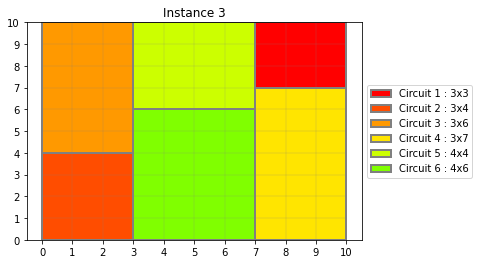

Plate width: 10
Plate height: 10
Elapsed time: 0.007s

Solving instance 4


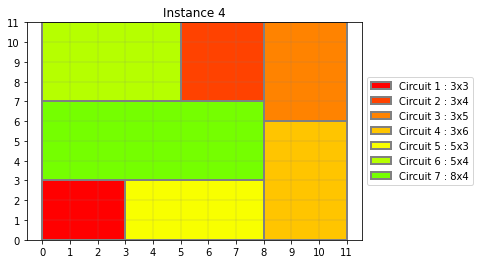

Plate width: 11
Plate height: 11
Elapsed time: 0.008s

Solving instance 5


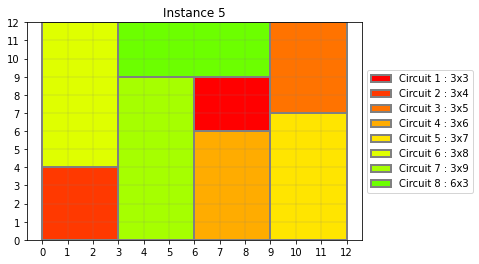

Plate width: 12
Plate height: 12
Elapsed time: 0.009s

Solving instance 6


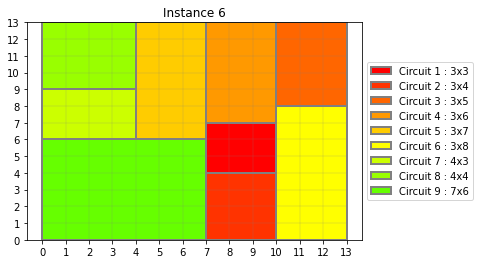

Plate width: 13
Plate height: 13
Elapsed time: 0.01s

Solving instance 7


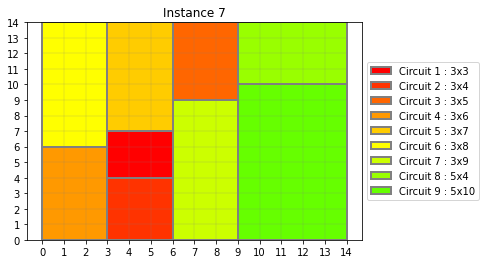

Plate width: 14
Plate height: 14
Elapsed time: 0.01s

Solving instance 8


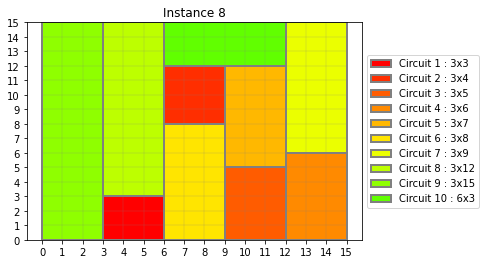

Plate width: 15
Plate height: 15
Elapsed time: 0.0119s

Solving instance 9


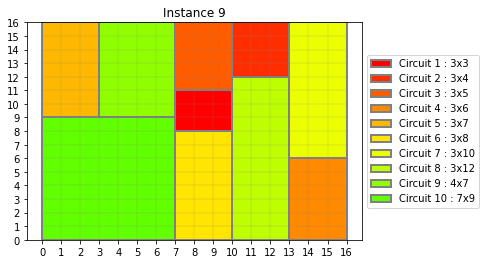

Plate width: 16
Plate height: 16
Elapsed time: 0.0099s

Solving instance 10


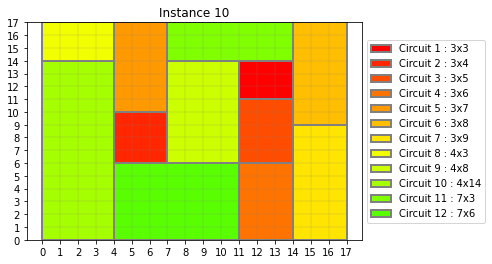

Plate width: 17
Plate height: 17
Elapsed time: 0.0209s

Solving instance 11


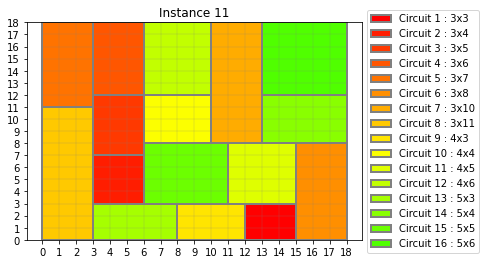

Plate width: 18
Plate height: 18
Elapsed time: 0.4318s

Solving instance 12


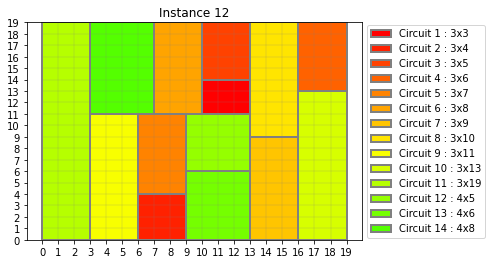

Plate width: 19
Plate height: 19
Elapsed time: 0.2922s

Solving instance 13


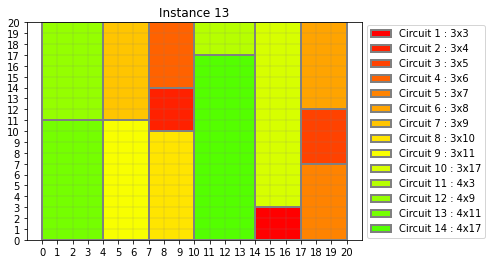

Plate width: 20
Plate height: 20
Elapsed time: 0.0489s

Solving instance 14


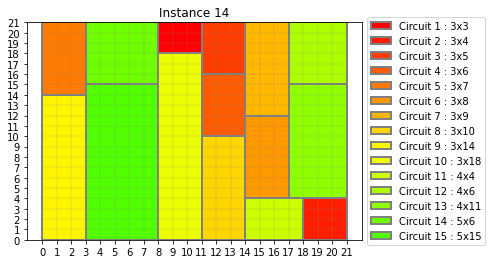

Plate width: 21
Plate height: 21
Elapsed time: 0.2892s

Solving instance 15


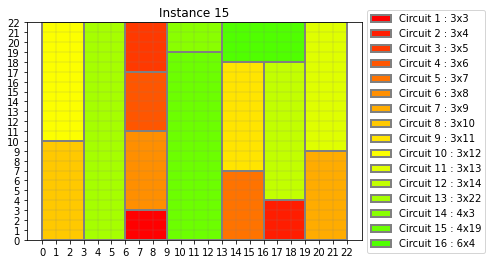

Plate width: 22
Plate height: 22
Elapsed time: 0.0359s

Solving instance 16


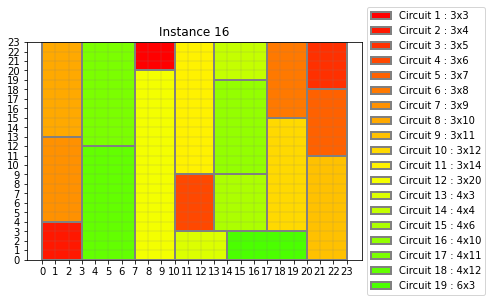

Plate width: 23
Plate height: 23
Elapsed time: 3.6313s

Solving instance 17


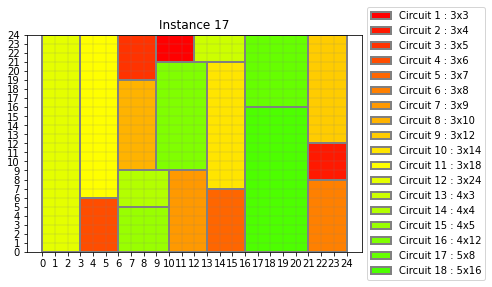

Plate width: 24
Plate height: 24
Elapsed time: 3.1436s

Solving instance 18


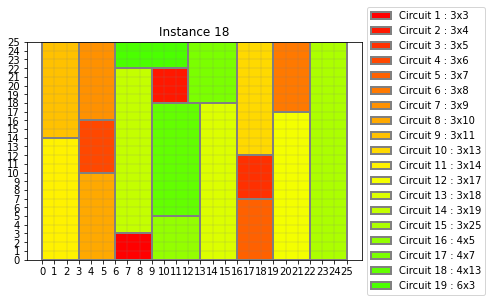

Plate width: 25
Plate height: 25
Elapsed time: 6.8729s

Solving instance 19


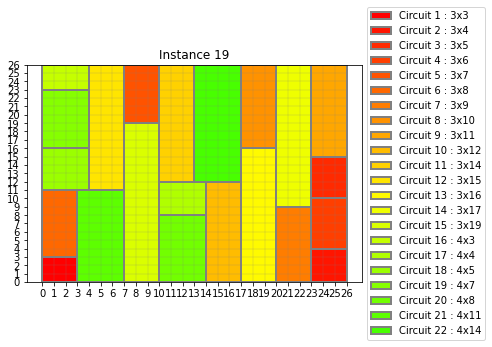

Plate width: 26
Plate height: 26
Elapsed time: 6.5874s

Solving instance 20


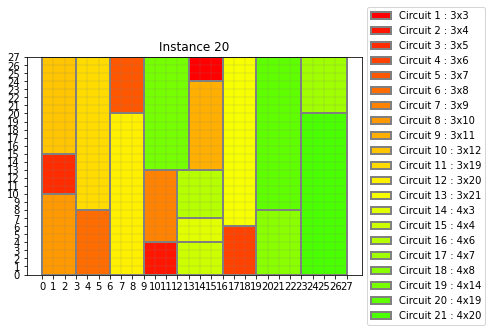

Plate width: 27
Plate height: 27
Elapsed time: 3.6602s

Solving instance 21


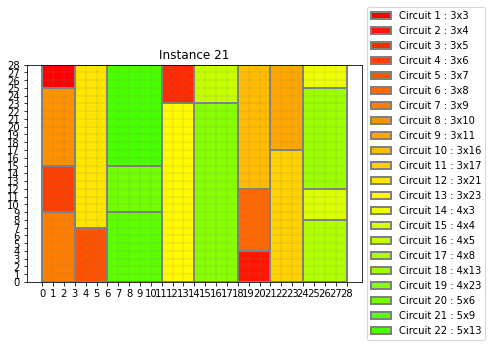

Plate width: 28
Plate height: 28
Elapsed time: 4.9547s

Solving instance 22


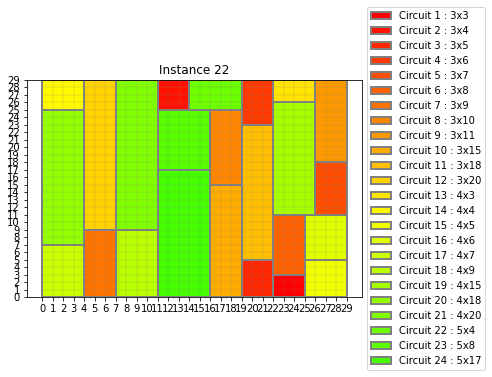

Plate width: 29
Plate height: 29
Elapsed time: 4.6759s

Solving instance 23


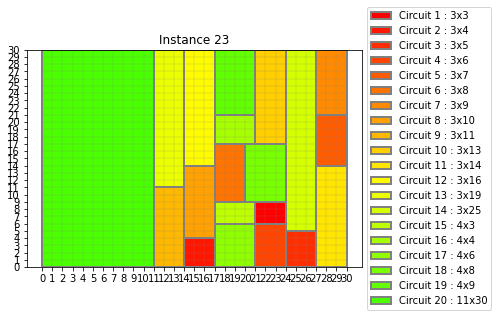

Plate width: 30
Plate height: 30
Elapsed time: 0.5276s

Solving instance 24


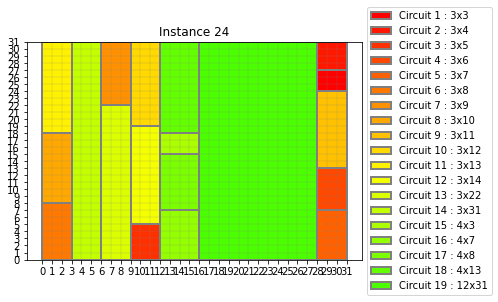

Plate width: 31
Plate height: 31
Elapsed time: 0.2064s

Solving instance 25


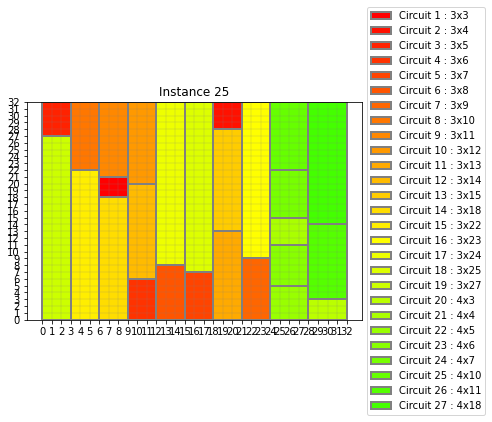

Plate width: 32
Plate height: 32
Elapsed time: 3.1994s

Solving instance 26


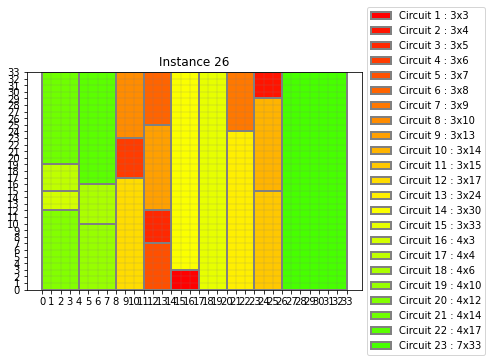

Plate width: 33
Plate height: 33
Elapsed time: 5.3413s

Solving instance 27


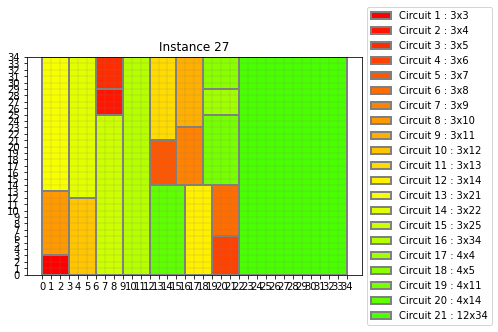

Plate width: 34
Plate height: 34
Elapsed time: 0.8148s

Solving instance 28


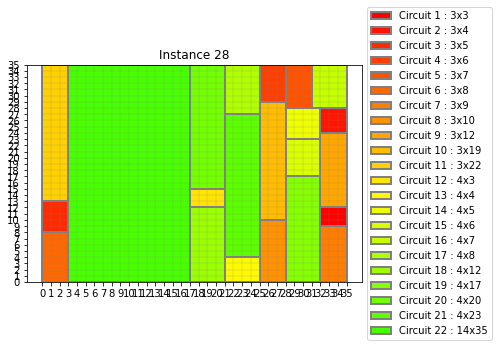

Plate width: 35
Plate height: 35
Elapsed time: 6.7888s

Solving instance 29


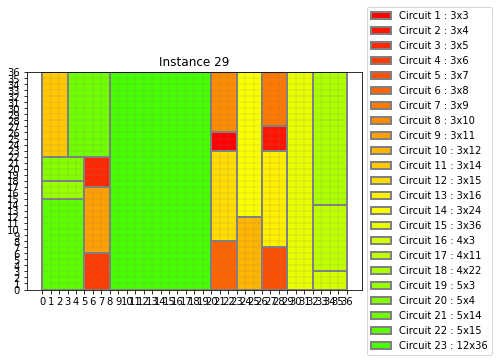

Plate width: 36
Plate height: 36
Elapsed time: 11.1412s

Solving instance 30


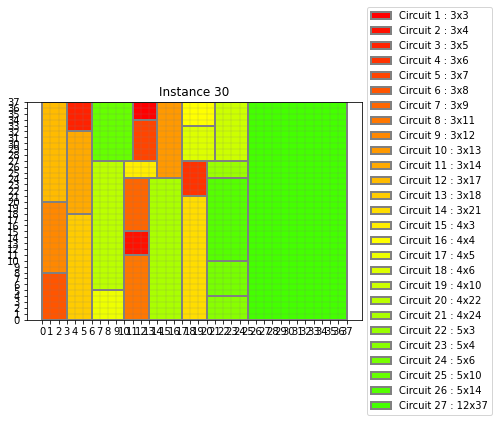

Plate width: 37
Plate height: 37
Elapsed time: 107.861s

Solving instance 31


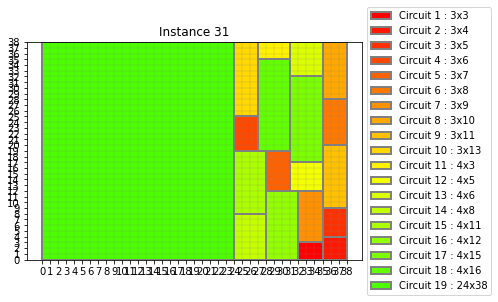

Plate width: 38
Plate height: 38
Elapsed time: 4.864s

Solving instance 32


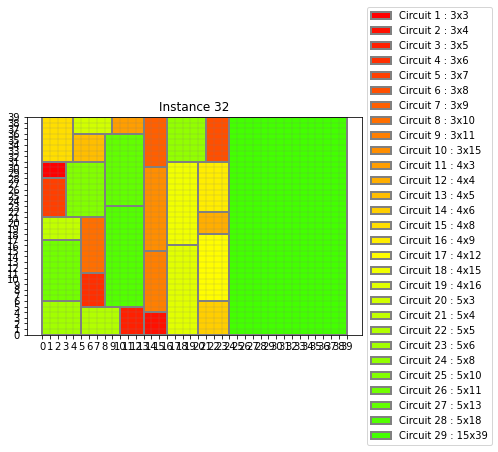

Plate width: 39
Plate height: 39
Elapsed time: 81.3862s

Solving instance 33


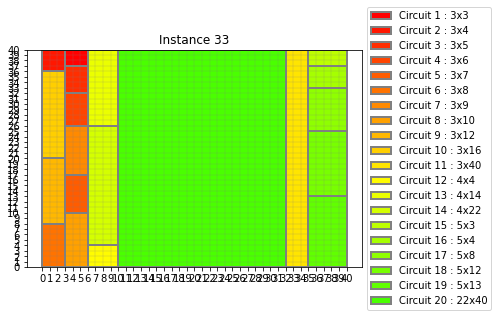

Plate width: 40
Plate height: 40
Elapsed time: 0.387s

Solving instance 34


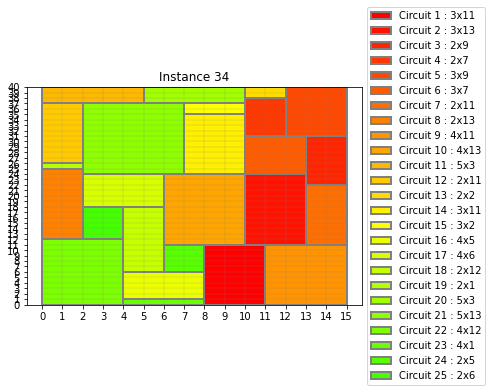

Plate width: 15
Plate height: 40
Elapsed time: 13.2735s

Solving instance 35


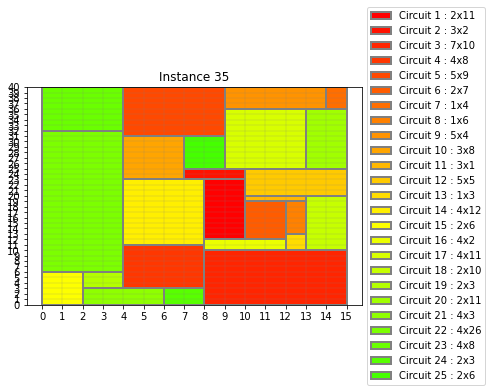

Plate width: 15
Plate height: 40
Elapsed time: 2.1553s

Solving instance 36


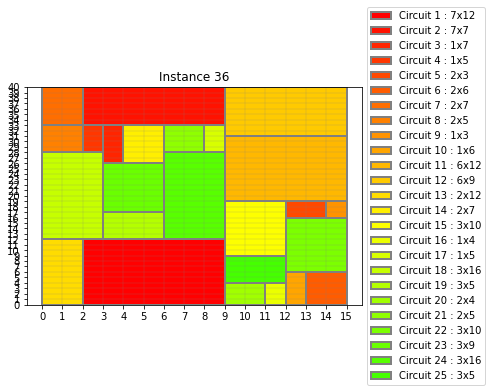

Plate width: 15
Plate height: 40
Elapsed time: 0.2463s

Solving instance 37


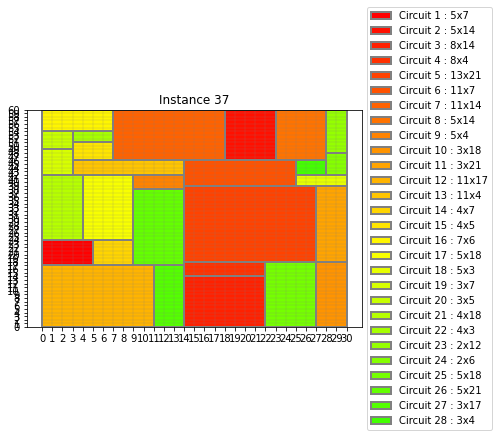

Plate width: 30
Plate height: 60
Elapsed time: 140.918s

Solving instance 38
Timed out
Solving instance 39


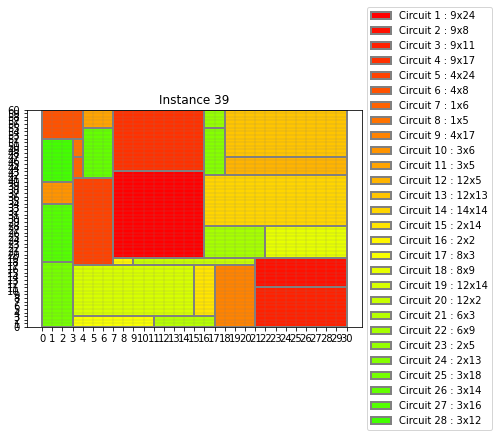

Plate width: 30
Plate height: 60
Elapsed time: 59.6472s

Solving instance 40
Timed out
Solved instances : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '39']
Timed out instances : ['38', '40']
Total solved : 38/40
Not solved : []
Elapsed times : {'1': 0.006, '2': 0.006, '3': 0.007, '4': 0.008, '5': 0.009, '6': 0.01, '7': 0.01, '8': 0.0119, '9': 0.0099, '10': 0.0209, '11': 0.4318, '12': 0.2922, '13': 0.0489, '14': 0.2892, '15': 0.0359, '16': 3.6313, '17': 3.1436, '18': 6.8729, '19': 6.5874, '20': 3.6602, '21': 4.9547, '22': 4.6759, '23': 0.5276, '24': 0.2064, '25': 3.1994, '26': 5.3413, '27': 0.8148, '28': 6.7888, '29': 11.1412, '30': 107.861, '31': 4.864, '32': 81.3862, '33': 0.387, '34': 13.2735, '35': 2.1553, '36': 0.2463, '37': 140.918, '39': 59.6472}
Mean time : 12.46


In [10]:
path = "../../instances/"
#With the following line we get the instances correctly sorted without changing names
input_files = sorted(sorted([path + i for i in os.listdir(path)], key=len)[:9]) + sorted(sorted([path + i for i in os.listdir(path)], key=len)[9:])
print(input_files)
times = {}
timed_out = []
no_sol = []


for i in input_files:  
  s = Solver()                                          
  plate_w, n, width, height = input.read_instance(i)    # Read instances from txt file
  instance_n = re.findall(r'\d+', i)[0]
  print("Solving instance {0}".format(instance_n))
                                    
  # === Variables ===
  plate_h = int(math.ceil(sum([width[i] * height[i] for i in range(n)]) / plate_w))

  c_x = [[Bool(f"x_{i+1}_{e}") for e in range(plate_w)] for i in range(n)]  
  c_y = [[Bool(f"y_{j+1}_{f}") for f in range(plate_h)] for j in range(n)] 

  lr = [[Bool(f"lr_{i+1}_{j+1}") if i != j else 0 for j in range(n)] for i in range(n)]
  ud = [[Bool(f"ud_{i+1}_{j+1}") if i != j else 0 for j in range(n)] for i in range(n)]

  e = [[j for j in range(0,plate_w-width[i])] for i in range(n)]
  f = [[j for j in range(0,plate_h-height[i])] for i in range(n)]


  # === Add constraints ===
  s.add(reduce_domain(n,plate_w,plate_h,width, height, c_x,c_y) +
        no_overlap_2(c_x, e, n) +
        no_overlap_2(c_y, f, n) +
        no_overlap_3(lr, c_x, width, plate_w) +
        no_overlap_3(ud, c_y, height, plate_h)  +
        no_overlap_4(lr, ud, n) +
        max_circuit(width, height, lr, ud, plate_w, plate_h) + 
        large_circuits(width, height, lr, ud, plate_w, plate_h) + 
        same_size(width, height, lr, ud)
  )
  s.set(timeout=300*1000)                               # Set timeout in milliseconds for solving   

  # === Set output directory ===
  out_path = "../out"
  if not os.path.isdir(out_path):                     
      os.mkdir(out_path)

  start_time = time.time()                              # Init start time
  
  if s.check() == sat:                                  # If model is SAT
      m = s.model()
      elapsed_time = round(time.time() - start_time, 4) # Calculate elapsed time
      x,y = evaluate_solution(m, c_x, c_y, n, plate_w, plate_h)
      circuits = [(wi, hi, xi, yi) for wi, hi, xi, yi in zip(width, height, x, y)]
      out = write_output(out_path, instance_n, plate_w, plate_h, circuits) # Write output on a txt file in the output directory

      # === Plot solution ===
      chip, circuits = output.load_solution(out)        
      title = "Instance {0}".format(instance_n)
      output.plot_grid(chip, circuits, title, i)
      print("Plate width: {0}\nPlate height: {1}".format(plate_w, plate_h))
      print("Elapsed time: " + str(elapsed_time) + "s\n")
      times[instance_n] = elapsed_time
  
  elif s.check() == unknown:                            # unknown means model is sat but an optimal solution was not found 
      print("Timed out")
      timed_out.append(instance_n)
  else:                                                 # Model is UNSAT
      print(s.check())      
      no_sol.append(instance_n)

print("Solved instances : {0}\n"    .format(list(times.keys())) +
      "Timed out instances : {0}\n" .format(timed_out) +
      "Total solved : {0}/{1}\n"    .format(len(times), len(input_files)) +
      "Not solved : {0}\n"          .format(no_sol) +
      "Elapsed times : {0}\n"       .format(times) +
      "Mean time : {0}"             .format(round(sum(times.values())/len(times),4)))

## Results

Best run:

```
Solved instances : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
Timed out instances : ['40']
Total solved : 39/40
Not solved : []
Elapsed times : {'1': 0.006, '2': 0.009, '3': 0.0089, '4': 0.01, '5': 0.012, '6': 0.016, '7': 0.015, '8': 0.014, '9': 0.013, '10': 0.0229, '11': 1.1521, '12': 0.2409, '13': 0.0389, '14': 0.1023, '15': 0.0405, '16': 5.3637, '17': 2.9731, '18': 2.8115, '19': 5.981, '20': 1.461, '21': 5.9088, '22': 65.0708, '23': 0.5376, '24': 0.2318, '25': 10.5095, '26': 7.6413, '27': 0.887, '28': 6.6631, '29': 4.3665, '30': 100.8437, '31': 4.8663, '32': 79.9773, '33': 0.2014, '34': 10.2187, '35': 0.8118, '36': 0.2458, '37': 40.2472, '38': 85.0263, '39': 6.174}
Mean time : 11.5569
```



In [ ]:
times = {'1': 0.006, '2': 0.009, '3': 0.0089, '4': 0.01, '5': 0.012, '6': 0.016, '7': 0.015, '8': 0.014, '9': 0.013, '10': 0.0229, '11': 1.1521, '12': 0.2409, '13': 0.0389, '14': 0.1023, '15': 0.0405, '16': 5.3637, '17': 2.9731, '18': 2.8115, '19': 5.981, '20': 1.461, '21': 5.9088, '22': 65.0708, '23': 0.5376, '24': 0.2318, '25': 10.5095, '26': 7.6413, '27': 0.887, '28': 6.6631, '29': 4.3665, '30': 100.8437, '31': 4.8663, '32': 79.9773, '33': 0.2014, '34': 10.2187, '35': 0.8118, '36': 0.2458, '37': 40.2472, '38': 85.0263, '39': 6.174}

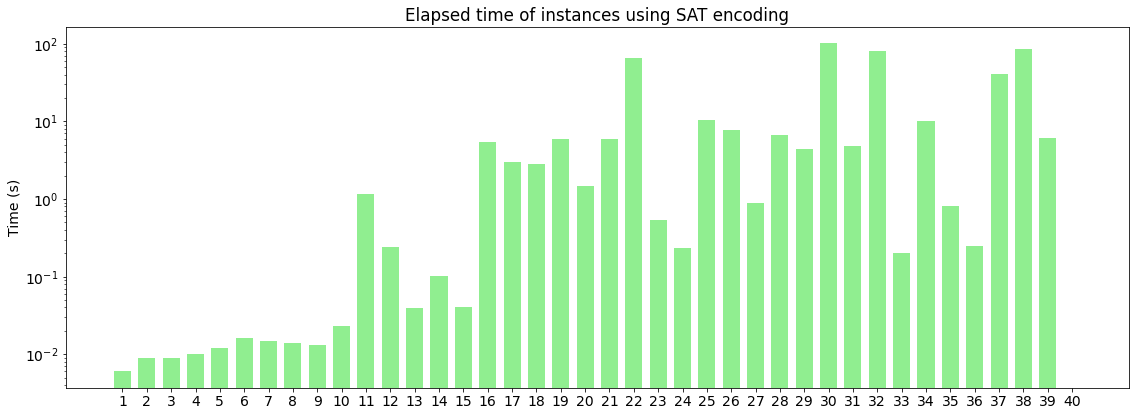

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)
plt.rcParams["font.size"] = 14

labels = np.arange(1, 41)  # the label locations
t = []
for i in range(1,41):
  if str(i) in times.keys():
      t.append(times.get(str(i)))
  else:
      t.append(0)

fig, ax = plt.subplots()
rects1 = ax.bar(labels, t, 0.7, color = 'lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_yscale('log')
ax.set_title('Elapsed time of instances using SAT encoding')
ax.set_xticks(labels)

fig.tight_layout()

plt.show()

# Model with rotation allowed (not working properly)

In [15]:
def correct_domain_r(n, plate_w, plate_h, width, height, x , y, r):
  '''
  @args:
    - n: number of circuits (int)
    - plate_w: maximum width of the plate (int)
    - plate_h: maximum height of the plate (int)
    - width: list of widths of the circuits (list of int)
    - height: list of heights of the circuits (list of int)
    - x: set of bool values indicating every x coordinate in the plate grid (list of list of Bool)
    - y: set of bool values indicating every y coordinate in the plate grid (list of list of Bool)
    - r: set of bool values indicating whether the circuit is rotated or not
  '''
  clauses = []
  for i in range(n): 
    # Variables exceeding the constraints are set to true
    for e in range(plate_w - width[i], plate_w):             # For each value in between max-width and max 
      clauses.append(And(x[i][e], Not(r[i])))
    for f in range(plate_h - height[i], plate_h):            # For each value in between max-height and max
      clauses.append(And(y[i][f], Not(r[i])))
  return clauses

In [16]:
def no_overlap_2_r(coord, size ,max , n):
    '''
    Two calls have to be made on this method for each coordinate: (x, e, n) and (y, f, n)
    @args:
      - coord: set of bool values indicating every x/y coordinate in the plate grid (list of list of Bool)
      - d: the set of possible values for each circuit (list of int)
      - n: number of circuits (int)
    '''
    clauses = []
    for i in range(n):
        for k in range(0, max - size[i]):
            clauses.append(Or(Not(coord[i][k]), coord[i][k+1]))
    return clauses

['../instances/ins-1.txt', '../instances/ins-2.txt', '../instances/ins-3.txt', '../instances/ins-4.txt', '../instances/ins-5.txt', '../instances/ins-6.txt', '../instances/ins-7.txt', '../instances/ins-8.txt', '../instances/ins-9.txt', '../instances/ins-10.txt', '../instances/ins-11.txt', '../instances/ins-12.txt', '../instances/ins-13.txt', '../instances/ins-14.txt', '../instances/ins-15.txt', '../instances/ins-16.txt', '../instances/ins-17.txt', '../instances/ins-18.txt', '../instances/ins-19.txt', '../instances/ins-20.txt', '../instances/ins-21.txt', '../instances/ins-22.txt', '../instances/ins-23.txt', '../instances/ins-24.txt', '../instances/ins-25.txt', '../instances/ins-26.txt', '../instances/ins-27.txt', '../instances/ins-28.txt', '../instances/ins-29.txt', '../instances/ins-30.txt', '../instances/ins-31.txt', '../instances/ins-32.txt', '../instances/ins-33.txt', '../instances/ins-34.txt', '../instances/ins-35.txt', '../instances/ins-36.txt', '../instances/ins-37.txt', '../insta

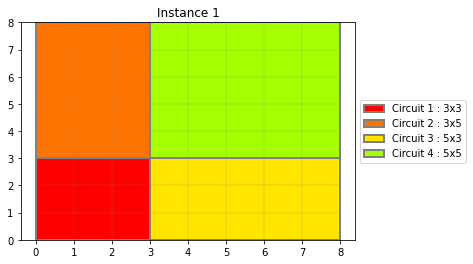

Plate width: 8
Plate height: 8
Elapsed time: 0.011s

Solving instance 2
[False, False, False, False, False]


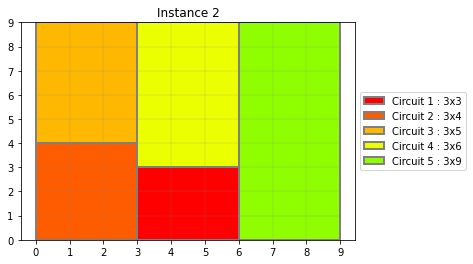

Plate width: 9
Plate height: 9
Elapsed time: 0.011s

Solving instance 3
[False, False, False, False, False, False]


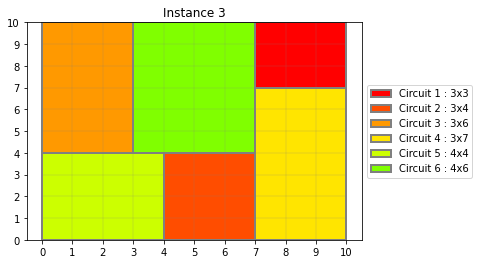

Plate width: 10
Plate height: 10
Elapsed time: 0.009s

Solving instance 4
[False, False, False, False, False, False, False]


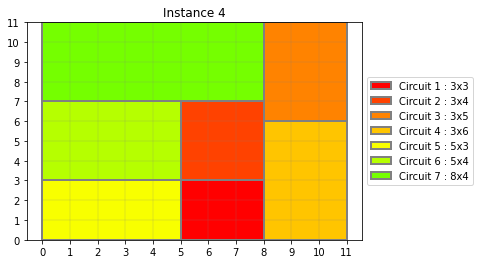

Plate width: 11
Plate height: 11
Elapsed time: 0.01s

Solving instance 5
[False, False, False, False, False, False, False, False]


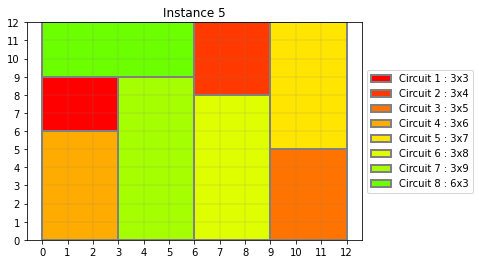

Plate width: 12
Plate height: 12
Elapsed time: 0.018s

Solving instance 6
[False, False, False, False, False, False, False, False, False]


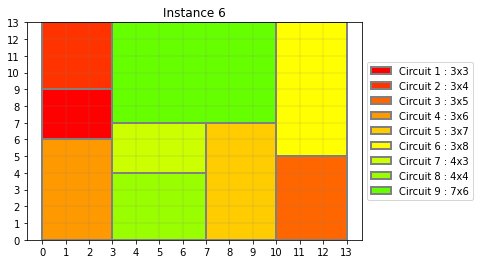

Plate width: 13
Plate height: 13
Elapsed time: 0.0189s

Solving instance 7
[False, False, False, False, False, False, False, False, False]


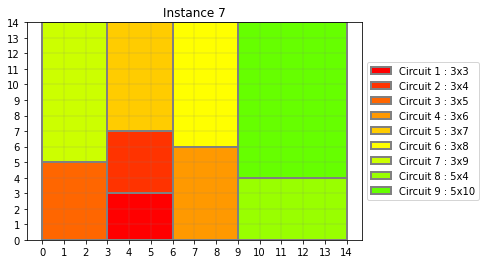

Plate width: 14
Plate height: 14
Elapsed time: 0.015s

Solving instance 8
[False, False, False, False, False, False, False, False, False, False]


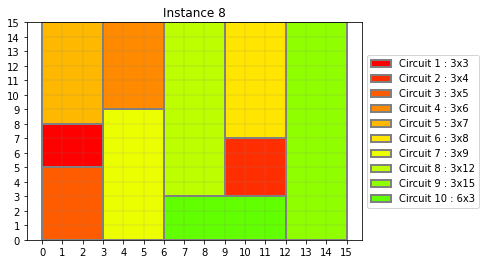

Plate width: 15
Plate height: 15
Elapsed time: 0.0199s

Solving instance 9
[False, False, False, False, False, False, False, False, False, False]


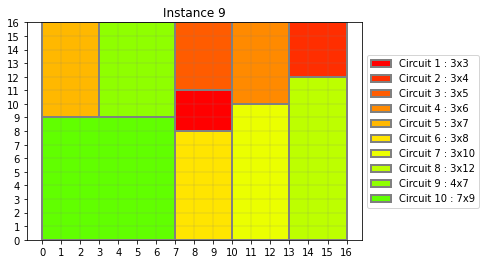

Plate width: 16
Plate height: 16
Elapsed time: 0.016s

Solving instance 10
[False, False, False, False, False, False, False, False, False, False, False, False]


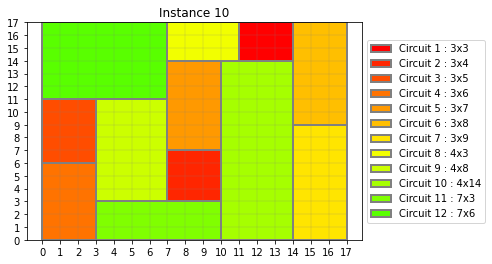

Plate width: 17
Plate height: 17
Elapsed time: 0.0259s

Solving instance 11
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


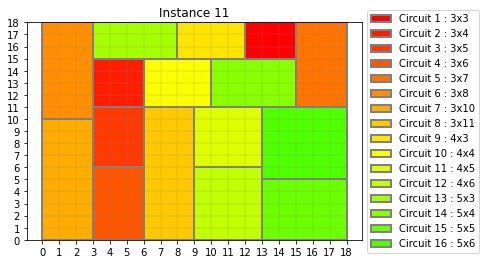

Plate width: 18
Plate height: 18
Elapsed time: 0.1287s

Solving instance 12
[False, False, False, False, False, False, False, False, False, False, False, False, False, False]


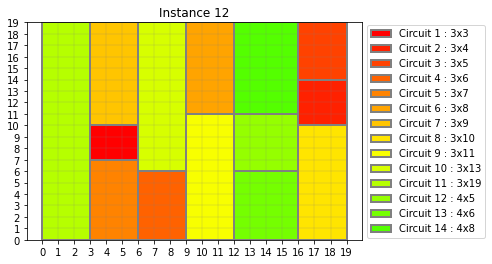

Plate width: 19
Plate height: 19
Elapsed time: 0.0678s

Solving instance 13
[False, False, False, False, False, False, False, False, False, False, False, False, False, False]


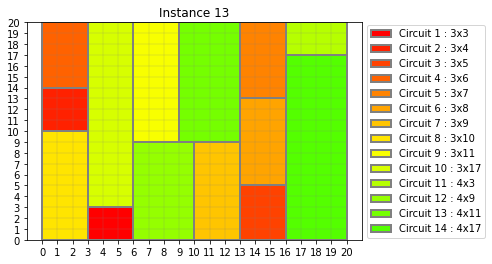

Plate width: 20
Plate height: 20
Elapsed time: 0.0489s

Solving instance 14
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


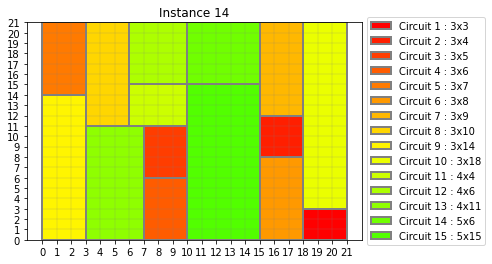

Plate width: 21
Plate height: 21
Elapsed time: 0.0679s

Solving instance 15
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


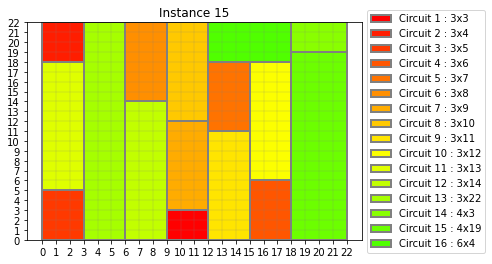

Plate width: 22
Plate height: 22
Elapsed time: 0.1386s

Solving instance 16
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


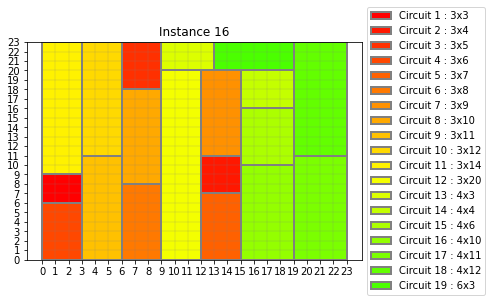

Plate width: 23
Plate height: 23
Elapsed time: 6.372s

Solving instance 17
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


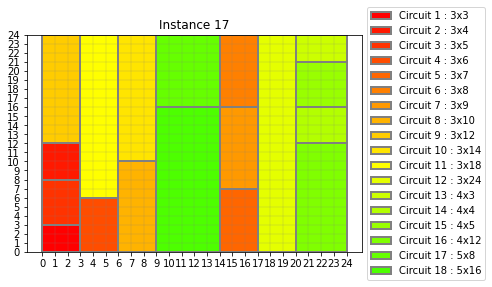

Plate width: 24
Plate height: 24
Elapsed time: 4.5468s

Solving instance 18
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


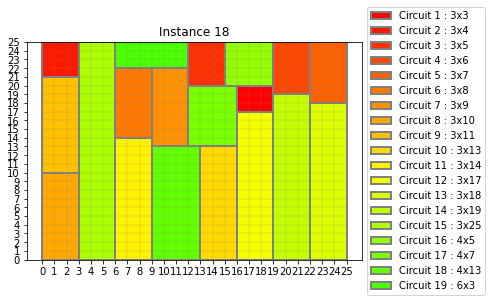

Plate width: 25
Plate height: 25
Elapsed time: 4.11s

Solving instance 19
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


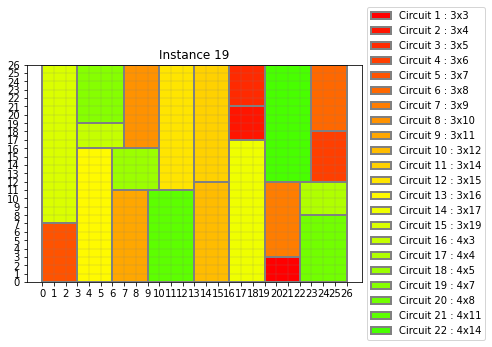

Plate width: 26
Plate height: 26
Elapsed time: 13.079s

Solving instance 20
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


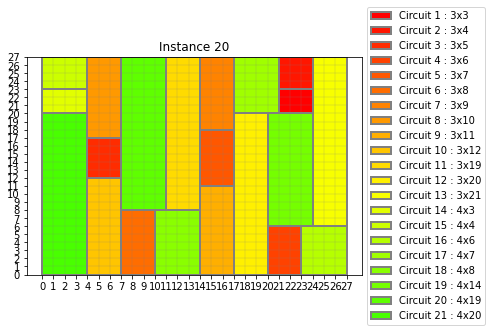

Plate width: 27
Plate height: 27
Elapsed time: 4.0601s

Solving instance 21
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


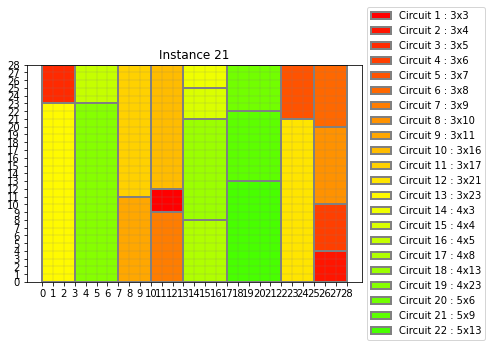

Plate width: 28
Plate height: 28
Elapsed time: 5.0425s

Solving instance 22
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


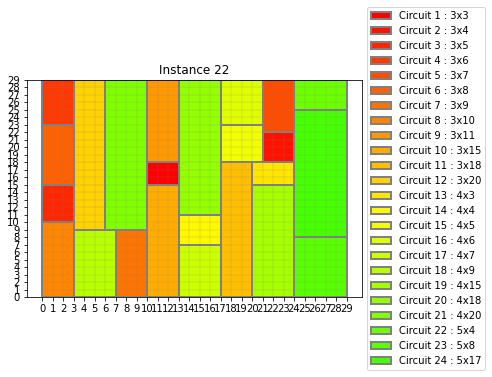

Plate width: 29
Plate height: 29
Elapsed time: 8.3317s

Solving instance 23
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


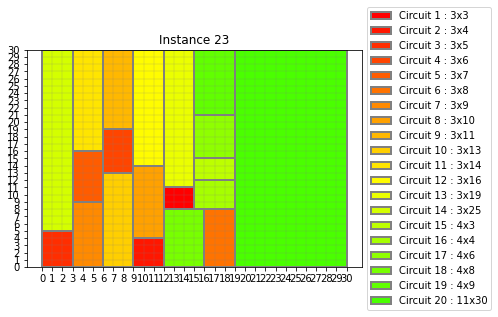

Plate width: 30
Plate height: 30
Elapsed time: 0.5126s

Solving instance 24
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


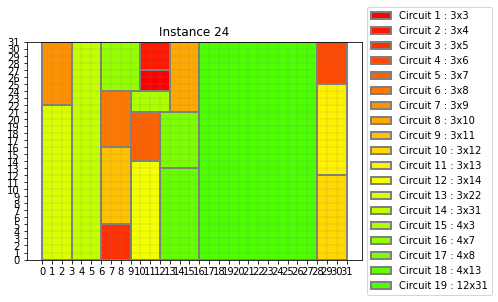

Plate width: 31
Plate height: 31
Elapsed time: 3.8946s

Solving instance 25
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


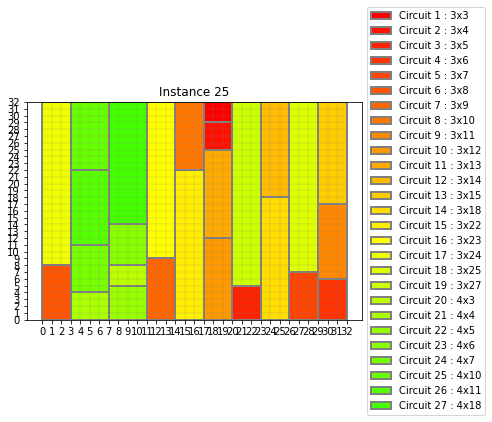

Plate width: 32
Plate height: 32
Elapsed time: 25.8678s

Solving instance 26
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


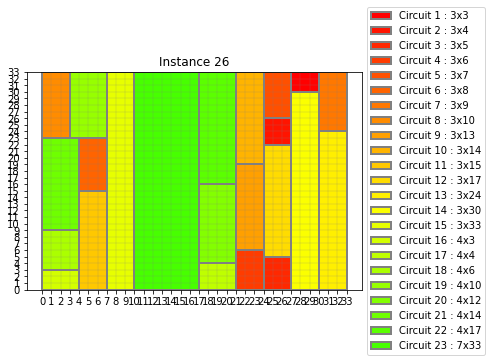

Plate width: 33
Plate height: 33
Elapsed time: 8.0315s

Solving instance 27
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


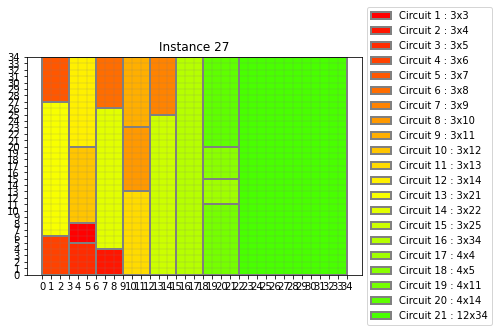

Plate width: 34
Plate height: 34
Elapsed time: 2.7177s

Solving instance 28
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


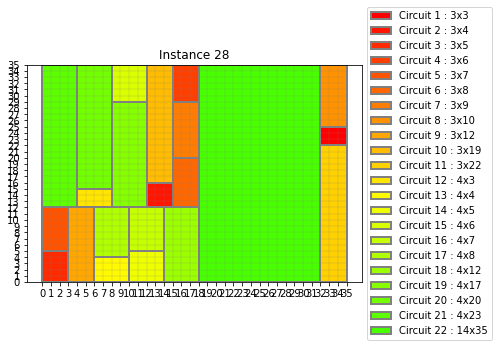

Plate width: 35
Plate height: 35
Elapsed time: 5.4405s

Solving instance 29
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


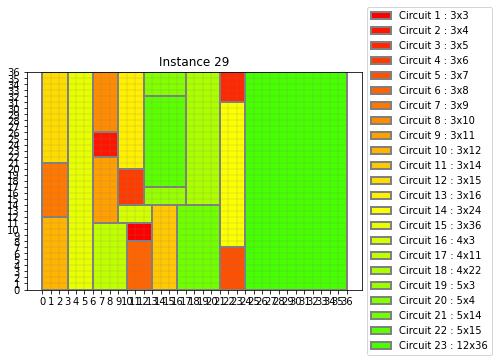

Plate width: 36
Plate height: 36
Elapsed time: 7.6699s

Solving instance 30
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


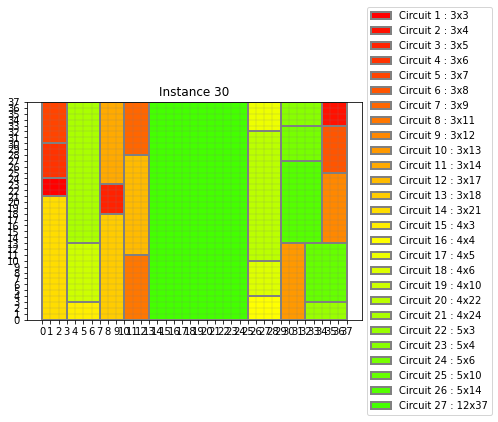

Plate width: 37
Plate height: 37
Elapsed time: 236.8366s

Solving instance 31
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


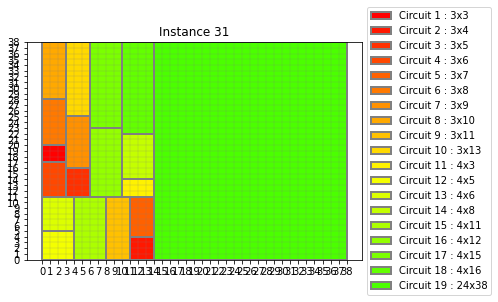

Plate width: 38
Plate height: 38
Elapsed time: 5.0884s

Solving instance 32
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


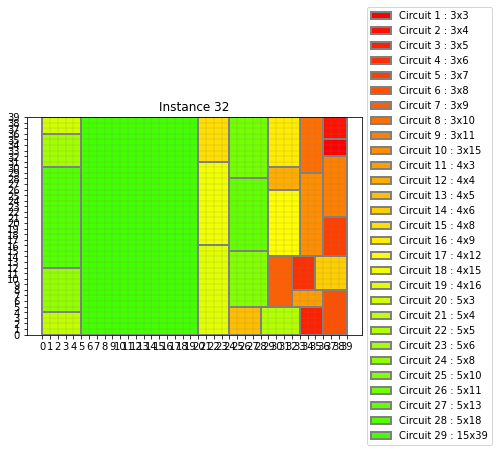

Plate width: 39
Plate height: 39
Elapsed time: 51.849s

Solving instance 33
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


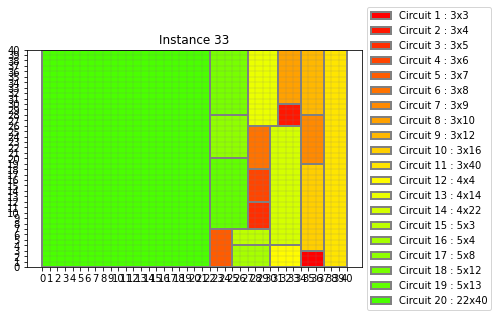

Plate width: 40
Plate height: 40
Elapsed time: 23.0962s

Solving instance 34
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


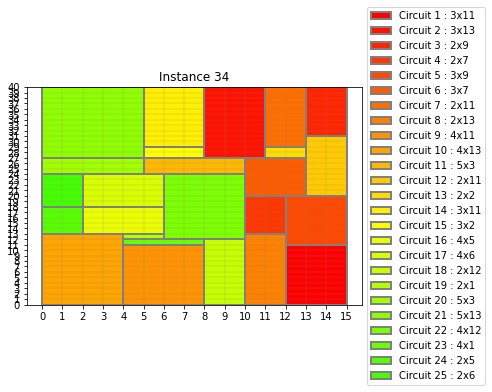

Plate width: 15
Plate height: 40
Elapsed time: 21.6403s

Solving instance 35
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


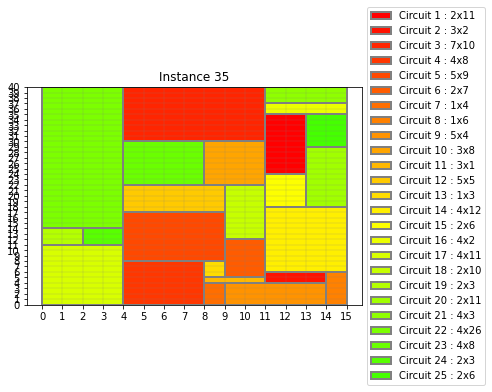

Plate width: 15
Plate height: 40
Elapsed time: 4.9448s

Solving instance 36
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


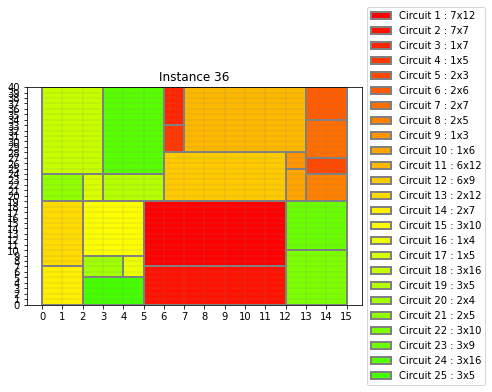

Plate width: 15
Plate height: 40
Elapsed time: 6.0295s

Solving instance 37
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


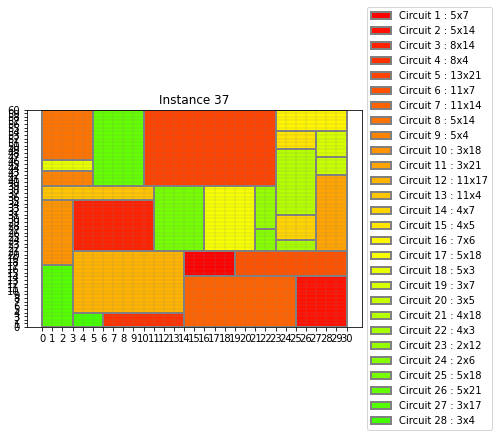

Plate width: 30
Plate height: 60
Elapsed time: 71.1109s

Solving instance 38
Timed out
Solving instance 39
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


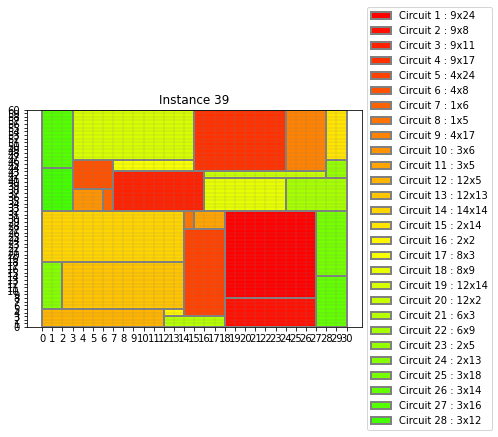

Plate width: 30
Plate height: 60
Elapsed time: 22.7431s

Solving instance 40
Timed out
Solved instances : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '39']
Timed out instances : ['38', '40']
Total solved : 38/40
Not solved : []
Elapsed times : {'1': 0.011, '2': 0.011, '3': 0.009, '4': 0.01, '5': 0.018, '6': 0.0189, '7': 0.015, '8': 0.0199, '9': 0.016, '10': 0.0259, '11': 0.1287, '12': 0.0678, '13': 0.0489, '14': 0.0679, '15': 0.1386, '16': 6.372, '17': 4.5468, '18': 4.11, '19': 13.079, '20': 4.0601, '21': 5.0425, '22': 8.3317, '23': 0.5126, '24': 3.8946, '25': 25.8678, '26': 8.0315, '27': 2.7177, '28': 5.4405, '29': 7.6699, '30': 236.8366, '31': 5.0884, '32': 51.849, '33': 23.0962, '34': 21.6403, '35': 4.9448, '36': 6.0295, '37': 71.1109, '39': 22.7431}
Mean time : 14.3058


In [17]:
path = "../instances/"
#With the following line we get the instances correctly sorted without changing names
input_files = sorted(sorted([path + i for i in os.listdir(path)], key=len)[:9]) + sorted(sorted([path + i for i in os.listdir(path)], key=len)[9:])
print(input_files)
times = {}
timed_out = []
no_sol = []


for i in input_files:  
  s = Solver()                                          
  plate_w, n, width, height = input.read_instance(i)    # Read instances from txt file
  instance_n = re.findall(r'\d+', i)[0]
  print("Solving instance {0}".format(instance_n))
                                    
  # === Variables ===
  plate_h = int(math.ceil(sum([width[i] * height[i] for i in range(n)]) / plate_w))

  c_x = [[Bool(f"x_{i+1}_{e}") for e in range(plate_w)] for i in range(n)]  
  c_y = [[Bool(f"y_{j+1}_{f}") for f in range(plate_h)] for j in range(n)] 

  lr = [[Bool(f"lr_{i+1}_{j+1}") if i != j else 0 for j in range(n)] for i in range(n)]
  ud = [[Bool(f"ud_{i+1}_{j+1}") if i != j else 0 for j in range(n)] for i in range(n)]

  r = [Bool(f"r_{i}") for i in range(n)]


  # === Add constraints ===
  s.add(correct_domain_r(n,plate_w,plate_h,width, height, c_x,c_y, r) +
        no_overlap_2_r(c_x, width, plate_w, n) +
        no_overlap_2_r(c_y, height, plate_h, n) +
        no_overlap_2_r(c_x, height, plate_w, n) + #Added no overlap with 2-literal clause also for height wrt x
        no_overlap_2_r(c_y, width, plate_h, n) + #Added no overlap with 2-literal clause also for width wrt y
        no_overlap_3(lr, c_x, width, plate_w) +
        no_overlap_3(ud, c_y, height, plate_h)  +
        no_overlap_4(lr, ud, n) 
        #max_circuit(width, height, lr, ud, plate_w, plate_h) + 
        #large_circuits(width, height, lr, ud, plate_w, plate_h) + 
        #same_size(width, height, lr, ud)
  )
  s.set(timeout=300*1000)                               # Set timeout in milliseconds for solving   

  # === Set output directory ===
  out_path = "out"
  if not os.path.isdir(out_path):                     
      os.mkdir(out_path)

  start_time = time.time()                              # Init start time
  
  if s.check() == sat:                                  # If model is SAT
      m = s.model()
      
      elapsed_time = round(time.time() - start_time, 4) # Calculate elapsed time
      x,y = evaluate_solution(m, c_x, c_y, n, plate_w, plate_h)
      circuits = [(wi, hi, xi, yi) for wi, hi, xi, yi in zip(width, height, x, y)]
      out = write_output(out_path, instance_n, plate_w, plate_h, circuits) # Write output on a txt file in the output directory
      rot = [is_true(m.eval(r[i])) for i in range(n)]
      print(rot)
      # === Plot solution ===
      chip, circuits = output.load_solution(out)        
      title = "Instance {0}".format(instance_n)
      output.plot_grid(chip, circuits, title, i)
      print("Plate width: {0}\nPlate height: {1}".format(plate_w, plate_h))
      print("Elapsed time: " + str(elapsed_time) + "s\n")
      times[instance_n] = elapsed_time
  
  elif s.check() == unknown:                            # unknown means model is sat but an optimal solution was not found 
      print("Timed out")
      timed_out.append(instance_n)
  else:                                                 # Model is UNSAT
      print(s.check())      
      no_sol.append(instance_n)

print("Solved instances : {0}\n"    .format(list(times.keys())) +
      "Timed out instances : {0}\n" .format(timed_out) +
      "Total solved : {0}/{1}\n"    .format(len(times), len(input_files)) +
      "Not solved : {0}\n"          .format(no_sol) +
      "Elapsed times : {0}\n"       .format(times) +
      "Mean time : {0}"             .format(round(sum(times.values())/len(times),4)))